In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from math import log, exp
import seaborn as sns
from tqdm import tqdm, tqdm_pandas

In [2]:
def compute_repeat_sales_index():
    
    a=%system Rscript repeat_sales.R
    
    data = pd.read_csv('.rsi_index_per_bed.csv')

    data = data.rename(columns={'Unnamed: 0':'Time'})

    data = data.bfill()

    data = data.replace('NONE', np.nan).dropna(axis=1)
    
    data.to_csv('rsi_index_per_bed.csv')
    
    data = data.iloc[1:]
    
    return data

In [3]:
def compute_repeat_rents_index():
    
    a=%system Rscript repeat_rents.R
    
    data = pd.read_csv('.rri_index_per_bed_2011_to_2019.csv')

    data = data.rename(columns={'Unnamed: 0':'Time'})

    data = data.bfill()

    data = data.replace('NONE', np.nan).dropna(axis=1)
    
    data.to_csv('rsi_index_per_bed.csv')
    
    data = data.iloc[1:]
    
    return data

In [4]:
def infer_past_prices(serie):
    y, b, p = serie[['year', 'beds', 'price']]
    return (log(p) - rri[str(b)].loc[y:].cumsum()).apply(exp)

In [5]:
def compute_agg_rental_prices():
    rent_data_agg = pd.read_excel('voa-average-rent-borough.xls', sheet_name='Raw data', \
                              skiprows=2, \
                              usecols=['Year', 'Area', 'Category', 'Count of rents', 'Average'])

    rent_data_agg.head()

    # We filter the data by target region. As the data is not postcode-precise, 
    # the most accurate region would be NW (nortwest)
    rent_data_agg = rent_data_agg[rent_data_agg['Area'] == 'NORTH WEST'].drop('Area', 1)

    rent_data_agg['Category'].unique()

    # We filter by properties having a specific number of rooms
    rent_data_agg = rent_data_agg[~rent_data_agg['Category'].isin(['Room', 'All categories'])]


    beds_dict = {
        'Studio':0,
        'One Bedroom':1,
        'Two Bedroom':2,
        'Three Bedroom':3,
        'Four or more Bedrooms':4,
    }

    rent_data_agg['beds'] = rent_data_agg['Category'].apply(lambda x: beds_dict[x])

    rent_data_agg[['Count of rents', 'Average']] = rent_data_agg[['Count of rents', 'Average']].astype(int)

    rent_data_agg = rent_data_agg.groupby(['Year', 'beds'])['Count of rents', 'Average'].mean().reset_index()

    rent_data_agg.to_csv('rent_data_agg.csv')
    
    return rent_data_agg

In [6]:
rsi = compute_repeat_sales_index()
rri = compute_repeat_rents_index()
rri.index = range(2012, 2020, 1)
rsi.index = range(1996, 2020, 1)
rri = rri.sort_index(ascending=False)

In [7]:
data = pd.read_csv('nw6_data_rent.csv', index_col = 0)
data_sales = pd.read_csv('nw6_data_sale.csv', index_col = 0)
data_sales = data_sales[data_sales['beds']>0]
data = data[data['beds']<5]
data_sales = data_sales[data_sales['beds']<5]

In [8]:
inf_prices = data.apply(infer_past_prices, axis=1)

inf_prices = inf_prices.join(data)

inf_prices = inf_prices.dropna()

In [9]:
data = inf_prices.melt(id_vars=data.columns[0:8].tolist(),\
              value_vars=range(2012, 2020)).rename(columns=\
                                                   {'price':'real_price',
                                                    'year':'real_year',
                                                    'variable':'year',
                                                    'value':'price'})

In [10]:
data.to_csv('nw6_data_rent_prev_years_prediction.csv')

In [11]:
def infer_future_prices(serie):
    y, b, p = serie[['year', 'beds', 'price']]
    b = str(b+1)
    y = max(1996, y)
    return (rsi.loc[y:2018,b] - rsi.loc[y,b] + log(p)).apply(exp)

In [12]:
inf_prices_sales = data_sales.apply(infer_future_prices, axis=1)

In [13]:
inf_prices_sales = data_sales.join(inf_prices_sales)

In [14]:
inf_prices_sales= inf_prices_sales.melt(id_vars=data_sales.columns[0:7].tolist(), value_vars=range(2012, 2019)).rename(columns=\
                                                   {'price':'real_price',
                                                    'year':'real_year',
                                                    'variable':'year',
                                                    'value':'price'})

In [15]:
inf_prices_sales.to_csv('nw6_data_price_fut_years_prediction.csv')

In [16]:
inf_prices_sales

,address,attributes,postcode,beds,real_price,date,real_year,year,price
0,"Flat 3, Newhaven Court, 189 Willesden Lane","Flat, Share of freehold, 2 Beds, 2 Baths, 1 Recep",NW6-7YN,2,437500,2008-04-01,2008,2012,523395.815417
1,"Flat 5, Newhaven Court, 189 Willesden Lane","Flat, Leasehold, 2 Beds, 2 Baths, 1 Recep",NW6-7YN,2,395000,2008-06-01,2008,2012,472551.650491
2,"Flat 7, Newhaven Court, 189 Willesden Lane","Flat, Freehold, 2 Beds, 2 Baths, 1 Recep",NW6-7YN,2,250000,2008-10-01,2008,2012,299083.323095
3,"Flat 1, 229 Kilburn Park Road","Flat, Leasehold, 2 Beds, 2 Baths, 1 Recep",NW6-5LG,2,340000,2008-02-01,2008,2012,406753.319410
4,35 Brondesbury Road,"Flat, Leasehold, 2 Beds, 1 Bath, 1 Recep",NW6-6BA,2,371000,2008-05-01,2008,2012,443839.651473
...,...,...,...,...,...,...,...,...,...
93179,78 Dyne Road,"Flat, 1 Bed, 1 Bath",NW6-7DS,1,290000,2005-08-01,2005,2018,586789.873983
93180,23 Burton Road,"Flat, Leasehold, 1 Bed, 1 Bath, 1 Recep",NW6-7LL,1,175000,2005-11-01,2005,2018,354097.337749
93181,37b Princess Road,"Flat, Leasehold, 1 Bed, 1 Bath, 1 Recep",NW6-5QT,1,190000,2005-03-01,2005,2018,384448.538127
93182,14 Dobson Close,"Flat, Leasehold, 1 Bed, 1 Bath, 1 Recep",NW6-4RS,1,197000,2005-08-01,2005,2018,398612.431637


In [17]:
rsi

,Time,1,2,3,4,5,6,7,8
1996,Time 2,0.100859,0.094256,0.092882,0.114264,0.067685,-0.169053,0.166422,0.352737
1997,Time 3,-0.283371,0.237562,0.285949,0.292865,0.238374,0.087565,0.385646,0.198088
1998,Time 4,0.399939,0.446943,0.509641,0.424720,0.465301,0.030749,0.648133,1.159355
1999,Time 5,0.792036,0.621011,0.647929,0.603413,0.666184,0.389488,0.818956,0.724181
2000,Time 6,0.805698,0.859928,0.855237,0.819236,0.888282,0.736376,0.902995,1.306615
2001,Time 7,0.984437,0.950988,0.957852,0.953187,0.960756,0.818805,0.645167,1.535330
2002,Time 8,1.255050,1.125672,1.085901,1.067905,1.061608,0.921705,1.277457,1.171507
2003,Time 9,1.314397,1.166818,1.164500,1.084654,1.138073,0.988425,1.546297,1.340708
2004,Time 10,1.004766,1.248676,1.215243,1.138526,1.240210,1.075815,1.569920,1.371504
2005,Time 11,1.098941,1.229921,1.219083,1.184628,1.215414,1.059801,1.465757,1.474974


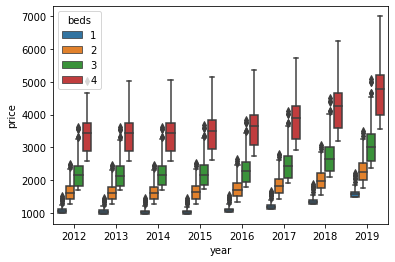

In [18]:
sns.boxplot(data=data, x='year', y='price', hue='beds')

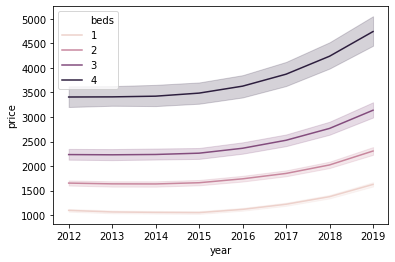

In [19]:
sns.lineplot(data=data, x='year', y='price', hue='beds')

Text(0.5, 1.0, 'Real sale prices over time')

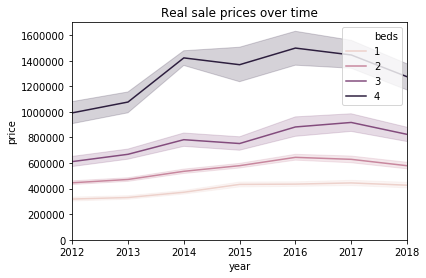

In [31]:
plt.xlim(2012, 2018)
plt.ylim(0, 1700000)
sns.lineplot(data=data_sales, x='year', y='price', hue='beds')
plt.title('Real sale prices over time')
plt.show()

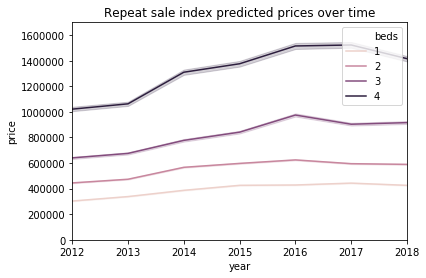

In [32]:
plt.xlim(2012, 2018)
plt.ylim(0, 1700000)
sns.lineplot(data=inf_prices_sales, x='year', y='price', hue='beds')
plt.title('Repeat sale index predicted prices over time')
plt.show()

In [20]:
rent_data_agg = compute_agg_rental_prices()
rent_data_agg = rent_data_agg[rent_data_agg['beds']>0]

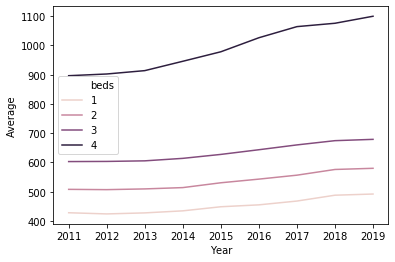

In [21]:
sns.lineplot(data=rent_data_agg, x='Year', y='Average', hue='beds')

Althought the trends are quite similar the absolute values are not. See email about this. In any case, the trends seem to make sense so they can be used.